# Embeddings

In [51]:
%matplotlib notebook
import keras
from keras import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

import pandas as pd
import numpy as np

from plotnine import *
from plotnine import options
options.set_option('figure_size' , (10,6))

    
import matplotlib.pyplot as plt

import seaborn as sns

from pandas.api.types import CategoricalDtype

In [52]:
df = pd.read_csv("~/.kaggle/datasets/new-york-city/nyc-east-river-bicycle-crossings/nyc-east-river-bicycle-counts.csv")
df['date'] = pd.to_datetime(df['Date'])
df['weekday'] = df['date'].dt.weekday
df['weekday_name'] = df['date'].dt.weekday_name

bridge = 'Total'
by_day = df.groupby('weekday_name')[[bridge]].sum()

<IPython.core.display.Javascript object>


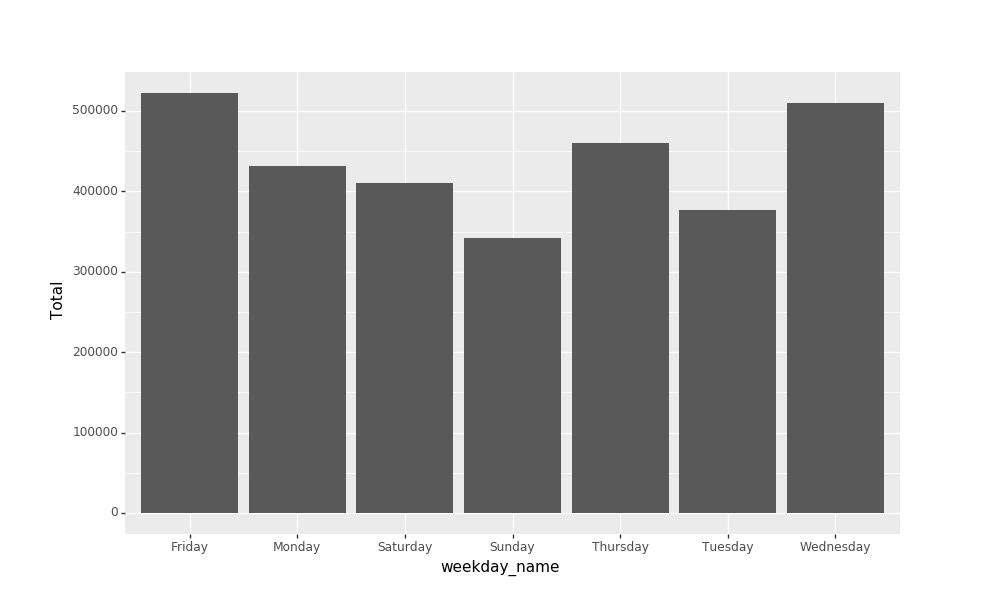

<ggplot: (8790872637567)>

In [53]:
ggplot(by_day.reset_index(), aes('weekday_name', bridge)) + geom_bar(stat = 'identity')

In [41]:
from pandas.api.types import CategoricalDtype
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_type = CategoricalDtype(categories=weekdays, ordered=True)
df['weekday_name'] = df['weekday_name'].astype(weekday_type)
by_day = df.groupby('weekday_name')[[bridge]].sum()

<IPython.core.display.Javascript object>


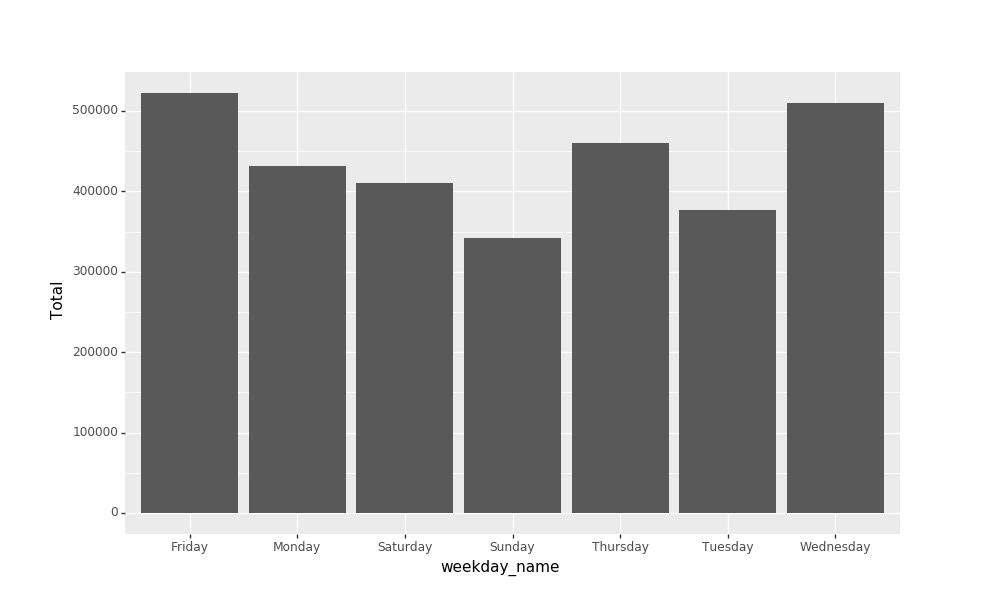

<ggplot: (-9223363245983252806)>

In [54]:
ggplot(by_day.reset_index(), aes('weekday_name', bridge)) + geom_bar(stat = 'identity')

In [57]:
df['users'] = df['Brooklyn Bridge']

df = df[df['users'] > 0]
df['scaled_users'] = (df['users'] - np.mean(df['users']))/np.std(df['users'])

emb_size = 3
embedding_names = [f'D{x+1}' for x in np.arange(emb_size)]

### Keras model

In [58]:
model = keras.Sequential()
model.add(Embedding(input_dim=7, output_dim=emb_size, input_length=1, name="embedding"))
model.add(Flatten())
model.add(Dense(units=40, activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))

In [59]:

model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
hh = model.fit(x=df[['weekday']], y=df[['scaled_users']], epochs=50,batch_size=2)

Epoch 1/50
210/210 [==============================] - 0s 1ms/step - loss: 1.0052 - acc: 0.0000e+00
Epoch 2/50
210/210 [==============================] - 0s 893us/step - loss: 1.0073 - acc: 0.0000e+00
Epoch 3/50
210/210 [==============================] - 0s 863us/step - loss: 1.0001 - acc: 0.0000e+00
Epoch 4/50
210/210 [==============================] - 0s 886us/step - loss: 0.9948 - acc: 0.0000e+00
Epoch 5/50
210/210 [==============================] - 0s 942us/step - loss: 0.9797 - acc: 0.0000e+00
Epoch 6/50
210/210 [==============================] - 0s 903us/step - loss: 0.9625 - acc: 0.0000e+00
Epoch 7/50
210/210 [==============================] - 0s 845us/step - loss: 0.9425 - acc: 0.0000e+00
Epoch 8/50
210/210 [==============================] - 0s 929us/step - loss: 0.9383 - acc: 0.0000e+00
Epoch 9/50
210/210 [==============================] - 0s 1ms/step - loss: 0.9164 - acc: 0.0000e+00A: 0s - loss: 0.9642 - acc: 0.0000e+
Epoch 10/50
210/210 [==============================] - 0s 1

In [60]:
mm = model.get_layer('embedding')
emb_matrix = mm.get_weights()[0]
emb_matrix

array([[-0.08149366,  0.06904344,  0.05854888],
       [ 0.25375608, -0.23749396, -0.01797867],
       [-0.41870362,  0.32552716,  0.03032824],
       [-0.11102595,  0.11974426,  0.00990532],
       [ 0.02550813,  0.03374586, -0.03680975],
       [ 0.47042754, -0.42819628, -0.00049888],
       [ 0.29037097, -0.2574139 , -0.0276002 ]], dtype=float32)

In [61]:
emp_df = pd.DataFrame(emb_matrix, columns = embedding_names)
emp_df['weekday'] = np.arange(0,7)

df = pd.merge(df, emp_df, on = 'weekday')
dummyw = pd.get_dummies(df['weekday_name'])
df_X = pd.concat([df, dummyw], ignore_index= False, axis = 1)
    
y = df_X['Williamsburg Bridge']
all_x = embedding_names + weekdays
df_X = df_X[all_x]
    
model = LinearRegression()
cat_x = df_X[weekdays]
emb_x = df_X[embedding_names]

In [62]:
bootstrap = ShuffleSplit(n_splits=100, random_state=0, test_size=0.2)

cat_scores = cross_val_score(model, cat_x, y, scoring="neg_mean_squared_error", cv=bootstrap)
emb_scores = cross_val_score(model, emb_x, y, scoring="neg_mean_squared_error", cv=bootstrap)

scores = pd.DataFrame({ 'categorical':-cat_scores, 'embedded':-emb_scores})
scores.mean()

categorical    3.063165e+06
embedded       2.968070e+06
dtype: float64

<IPython.core.display.Javascript object>


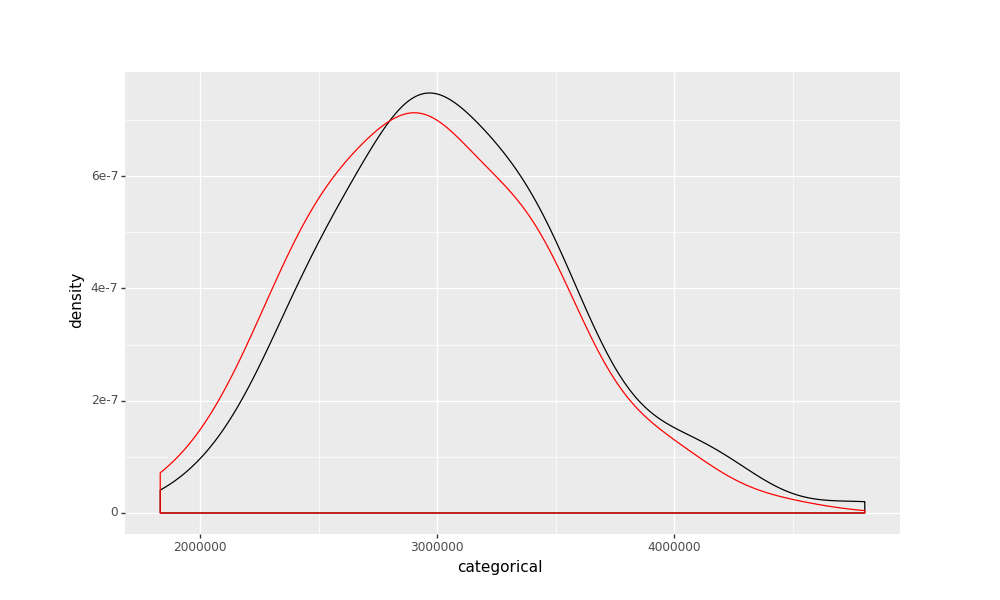

<ggplot: (8790872878358)>

In [63]:
ggplot(scores, aes('categorical')) + geom_density() + geom_density(aes('embedded'), color = 'red')

In [65]:
corr_mat = emp_df.drop('weekday', axis = 1).transpose().corr()
corr_mat.columns = weekdays 
corr_mat['weekdays_name'] = weekdays
corr_mat.set_index('weekdays_name', inplace = True)

sns.heatmap(corr_mat)
sns.heatmap(emp_df.drop('weekday', axis = 1))
plt.show()

AttributeError: 'YAxis' object has no attribute 'tick_right'

<IPython.core.display.Javascript object>


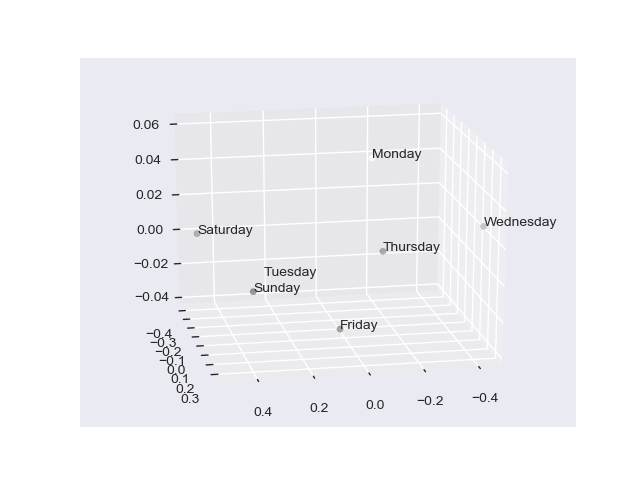

In [64]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(xs = emp_df['D1'], ys = emp_df['D2'], zs = emp_df['D3'], c = emp_df['weekday'])

for row_num, day in emp_df.iterrows():
    ax.text(x = day['D1'] , y = day['D2'], z = day['D3'], s = weekdays[row_num])

plt.show()